# Extracting field data from hand-filled forms: prototyping extraction pipeline

RE Sources has been monitoring the quality of stormwater outfalls in the Salish Sea for a few years, and they have a somewhat labor-intensive data entry process that Cascade STEAM has offered to automate. I'm volunteering to work on countour project, in collaboration with Kris Keillor, and this notebook serves as a WIP proof of concept for extracting data from stormwater monitoring field datasheets.

Currently, data collectors in the field handwrite observations in a printed PDF, and then periodically someone manually enters these observations into the database. It takes quite a bit of time to do, so they batch it out, and so it can be a while before it gets done, costing volunteer and paid hours along with creating a lag in the availability of research data for analysis and reporting.

Ultimately, we might like to create a mobile app for data collectors to enter observations into directly. But, for now, we've decided to start with their existing habits and build something smaller and perhaps more managable. So, we are working on a tool to apply optical character recognition (OCR) to read the hand-filled forms and extract the observations. This allows the users to continue to use pen and paper while shortening the time and labor needed to enter the data from the froms into the database.

## Pipeline overview

At a high level, we need to:

1. Create a template of the form, including locating fiducial points and text fields (regions of interest, or ROIs) that we can reliably find on the filled-out input forms.
2. Transform the input forms to align them to the template based on their fiducial points, applying image preprocessing as needed to clarify the fiducial points.
3. Break down the transformed input images into their ROIs using the template's ROI coordinates.
4. Apply OCR to read the handwritten text into a datastructure, applying image preprocessing as needed to clarify the handwritten text.


## Env setup notes

```bash
conda create -n stormwater_exp python=3.12 -y
conda activate stormwater_exp
pip install opencv-python matplotlib pymupdf numpy typeguard
# opencv-python 4.11.0.86 (`cv2`)
# matplotlib 3.10.3
# pymupdf 1.26.0 (`fitz`)
# numpy 2.2.6
# typeguard 4.4.3
# NOTE: VS Code also installed IPython: 9.3.0
```

Should't need `matplotlib` for extraction, just for exploration in the notebook.

## Create template, with fiducal points.

### Create template image.

To create a crisp template image, we're turning the PDF into an image, avoiding problems with photographing a paper template. We use PyMuPDF's `fitz` package to rasterize the PDF into an image.

In [1]:
import numpy as np
import cv2 # OpenCV
import fitz  # PyMuPDF
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Any, Final
from typeguard import typechecked

from pprint import pp
from IPython.display import Image
# Allows all output from a cell to display, instead of just the last one.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [2]:
SCANNED_DPI: Final[int] = 600
TEMPLATE_DPI: Final[int] = 600

SCANNED_PDF_PATH: Final[Path] = Path("images/ideal_form_scanned_600_DPI_color.pdf")
TEMPLATE_PATH: Final[Path] = Path("Field-Datasheet-Current-ver-4.4-1-29-2025.pdf")
TEMPLATE_WITH_FIELDS_PATH: Final[Path] = Path("Field-Datasheet-Current-ver-4.4-1-29-2025_FORM_FILLABLE.pdf")

FIDUCIAL_THRESHOLD: Final[int] = 200

In [3]:
template_doc = fitz.open(TEMPLATE_PATH)
template_with_fields_doc = fitz.open(TEMPLATE_WITH_FIELDS_PATH)
template_page = template_doc[0]
template_w_fields_page = template_with_fields_doc[0]

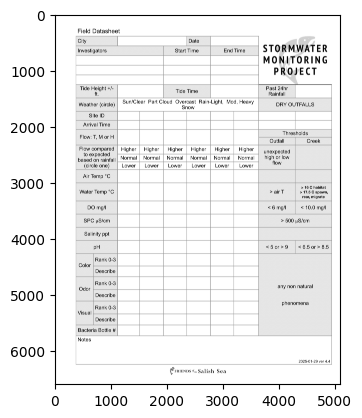

In [4]:
# @typechecked
def rasterize_PDF_to_image(
    page: fitz.Page,
    dpi: int
) -> cv2.Mat | np.ndarray[Any, np.dtype[np.integer[Any] | np.floating[Any]]]:
    """Rasterizes a PDF page to an image at the specified DPI.

    Args:
        page: The PDF page to rasterize.
        dpi: The desired DPI for the output image.

    Returns:
        The rasterized image as an OpenCV matrix (Numpy array).
    """
    # TODO: Verify that 72 is the correct denominator for DPI in this context.
    scale = dpi / 72  # PDF “points” are 1/72 inch
    mat  = fitz.Matrix(scale, scale)
    pix = page.get_pixmap(matrix=mat)
    img_arr = np.frombuffer(pix.samples, dtype=np.uint8).reshape((pix.h, pix.w, pix.n))
    if pix.n == 4:  # Drop alpha channel if present.
        img_arr = img_arr[:, :, :3]

    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_RGB2GRAY)

    return img_gray


template_gray = rasterize_PDF_to_image(page=template_page, dpi=TEMPLATE_DPI)
plt.imshow(template_gray, cmap='gray')

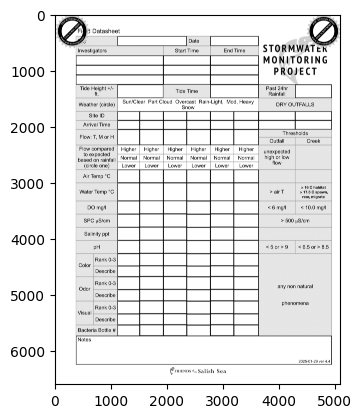

In [5]:
template_w_fields_gray = rasterize_PDF_to_image(page=template_w_fields_page, dpi=TEMPLATE_DPI)
plt.imshow(template_w_fields_gray, cmap='gray')


### Find template fiducials.

We need to find three, well-spaced, noncolinear points on the template that we can reliably find on input images. We'll use these to apply an affine transformation to the input images' pixel matrices. (NOTE: We'd need to find four points and apply a homographic transform if we took photos of the input images, but we're scanning the images instead of taking photos, so it reduces the problem space to fewer dimensions to transform along, as well as removing the problem of background surface noise.)

TODO: We use ... ?

In [6]:
# TODO: Keep trying, but try other methods outlined in Asana.
# @typechecked
def get_fiducial_points(
    img: cv2.Mat | np.ndarray[Any, np.dtype[np.integer[Any] | np.floating[Any]]]
) -> np.ndarray[tuple[int, int], np.dtype[np.float32]]:
    """Detect fiducial points in the image.

    Finds the four corners of a printed form by detecting contours
    that resemble the fiducial marks. The fiducial points are expected
    to be in the order: top-left, top-right, bottom-right, bottom-left.
    
    Args:
        img: The input image in grayscale.

    Returns:
        An array of detected fiducial points as (x, y) coordinates.
    """
    ret, img_thresh = cv2.threshold(
        src=img,
        thresh=FIDUCIAL_THRESHOLD,
        maxval=255,
        type=cv2.THRESH_BINARY_INV,
    )
    # print(f"Thresholding result: {ret}")

    img_thresh = cv2.medianBlur(
        src=img_thresh,
        ksize=3,
    )
    contours, hierarchy = cv2.findContours(
        image=img_thresh,
        mode=cv2.RETR_EXTERNAL,
        method=cv2.CHAIN_APPROX_SIMPLE
    )
    # print(f"Hierarchy: {hierarchy}")

    print(f"Image shape: {img.shape}")

    largest_area = 0
    x, y, w, h = 0, 0, 0, 0
    for contour in contours:
        countour_x, countour_y, countour_w, countour_h = cv2.boundingRect(array=contour)
        countour_area = countour_w * countour_h
        if countour_area > largest_area:
            largest_area = countour_area
            x, y, w, h = countour_x, countour_y, countour_w, countour_h
        elif countour_area == largest_area:
            print(f"Found another contour with the same area: {countour_area} at ({countour_x}, {countour_y}) with size ({countour_w}, {countour_h})")

    fiducial_points = np.array([
        [x, y],
        [x + w - 1, y],
        [x + w - 1, y + h - 1],
        [x, y + h - 1]
    ], dtype=np.float32)

    return fiducial_points


template_fiducial_points = get_fiducial_points(img=template_gray)
print(f"Template fiducial points: {template_fiducial_points}")

Image shape: (6600, 5100)
Template fiducial points: [[ 370.  392.]
 [4939.  392.]
 [4939. 6254.]
 [ 370. 6254.]]



### Find template ROIs.

We need to define the ROI bounding boxes so we can reliably find them in the input images once they're aligned.

#### Find template PDF's fields coordinates.

We're using `fitz` to locate the fillable fields as "widgets".

In [7]:
widgets = template_w_fields_page.widgets()

#### Convert PDF coordinates to pixel coordinates.

Since the coordinates are in PDF coordinates, we scale them to the image to convert them to pixel coordinates so we can find them in the images.

In [8]:
# @typechecked
def convert_fitz_rect_to_pixel_rect(
    fitz_rect: fitz.Rect,
    fitz_page: fitz.Page,
    image_shape: np.ndarray[tuple[int, int], np.dtype[np.uint8]]
) -> tuple[int, int, int, int]:
    """Convert a PyMuPDF Rect to pixel coordinates in a cv2 image.
    
    Args:
        fitz_rect: The PyMuPDF Rect to convert.
        fitz_page: The PyMuPDF Page containing the Rect.
        image_shape: The shape of the image as a Numpy array.

    Returns:
        A tuple of pixel coordinates (x0, y0, x1, y1) corresponding to the Rect.
    """
    width_scale = image_shape.shape[1] / fitz_page.rect.width
    height_scale = image_shape.shape[0] / fitz_page.rect.height

    x0 = int(np.round(fitz_rect.x0 * width_scale))
    y0 = int(np.round(fitz_rect.y0 * height_scale))
    x1 = int(np.round(fitz_rect.x1 * width_scale))
    y1 = int(np.round(fitz_rect.y1 * height_scale))

    return (x0, y0, x1, y1)


ROIs = {}
for widget in widgets:
    field_rect = convert_fitz_rect_to_pixel_rect(
        fitz_rect=widget.rect,
        fitz_page=template_page,
        image_shape=template_gray
    )
    ROIs[widget.field_name] = {"template_rect": field_rect}

pp(ROIs)

{'City': {'template_rect': (1115, 397, 2350, 569)},
 'Date': {'template_rect': (2770, 397, 3632, 569)},
 'Investigators1': {'template_rect': (374, 742, 1931, 914)},
 'Investigators2': {'template_rect': (374, 914, 1931, 1087)},
 'Investigators3': {'template_rect': (374, 1087, 1931, 1260)},
 'StartTime1': {'template_rect': (1931, 742, 2770, 914)},
 'StartTime2': {'template_rect': (1931, 914, 2770, 1087)},
 'StartTime3': {'template_rect': (1931, 1087, 2770, 1260)},
 'EndTime1': {'template_rect': (2770, 742, 3632, 914)},
 'EndTime2': {'template_rect': (2770, 914, 3632, 1087)},
 'EndTime3': {'template_rect': (2770, 1087, 3632, 1260)},
 'TideHeight': {'template_rect': (1115, 1260, 1931, 1498)},
 'TideTime': {'template_rect': (2770, 1260, 3632, 1498)},
 'Rainfall': {'template_rect': (4283, 1260, 4935, 1498)},
 'SiteID1': {'template_rect': (1115, 1737, 1512, 1899)},
 'SiteID2': {'template_rect': (1512, 1737, 1931, 1899)},
 'SiteID3': {'template_rect': (1931, 1737, 2350, 1899)},
 'SiteID4': {'t

## Find input fiducials and align to template.

Next we find the same relative fiducial points on each input image that we found on the template, and we use those points to perform a transformation on the input image pixel matrix that aligns it with the template image. This allows us to, in the next step, use the template ROI coordinates to find the ROIs in the input images.

### Convert scanned input PDFs to images.

In the same way that we rasterized the template PDF into an image, we rasterize each scanned input PDF into an image.

We scan the forms ahead of time instead of taking a photo so the images are straight on and require a simpler transformation with fewer fiducial points to align them to the template, and because it mitigates the problems of variable lighting and backgrounds.

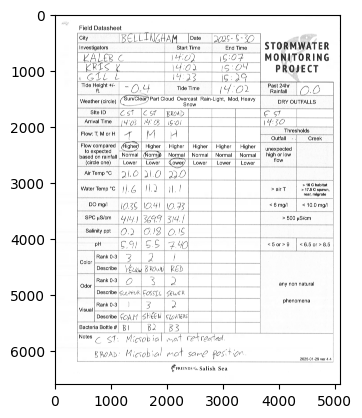

In [9]:
input_doc = fitz.open(SCANNED_PDF_PATH)
input_page = input_doc[0]

input_img_gray = rasterize_PDF_to_image(page=input_page, dpi=SCANNED_DPI)
plt.imshow(input_img_gray, cmap='gray')


### Find input fiducials.

Using the same process that we used to find the template fiducials (?), we find the fiducials of each input image.

In [10]:
input_img_fiducial_points = get_fiducial_points(img=input_img_gray)
print(f"Input image fiducial points: {input_img_fiducial_points}")

Image shape: (6600, 5100)
Input image fiducial points: [[ 392.  325.]
 [4969.  325.]
 [4969. 6214.]
 [ 392. 6214.]]


### Align input images to template.

Using an affine transformation provided by `cv2`, we plug in each image's fiducials along with the image and the template fiducials to transform each image to align with the template.

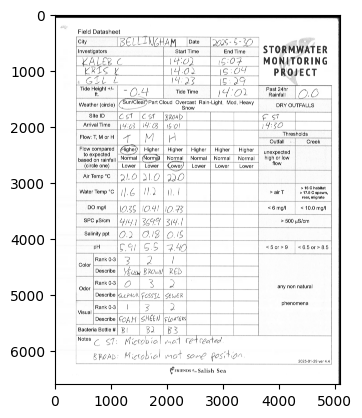

In [11]:
M = cv2.getPerspectiveTransform(
    src=input_img_fiducial_points,
    dst=template_fiducial_points
)
input_img_warped = cv2.warpPerspective(
    src=input_img_gray,
    M=M,
    dsize=(template_gray.shape[1], template_gray.shape[0])
)

plt.imshow(input_img_warped, cmap='gray')


## Break down input image into ROI images.

Now we can pull out smaller images for each ROI in each input image, using the coordinates of each ROI established in the template.

In [12]:
for roi_field_name, template_rect in ROIs.items():
    x0, y0, x1, y1 = template_rect["template_rect"]
    roi_img = input_img_warped[y0:y1, x0:x1]
    ROIs[roi_field_name]["roi"] = roi_img

    _ = cv2.imwrite(Path(f"scratch/roi_{roi_field_name}.jpg"), roi_img)

pp(ROIs)

{'City': {'template_rect': (1115, 397, 2350, 569),
          'roi': array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [218, 138, 138, ..., 255, 255, 243],
       [155, 140, 140, ..., 255, 255, 255],
       [142, 142, 142, ..., 255, 255, 204]],
      shape=(172, 1235), dtype=uint8)},
 'Date': {'template_rect': (2770, 397, 3632, 569),
          'roi': array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [128, 122, 122, ..., 255, 255, 255],
       [130, 124, 124, ..., 255, 255, 255],
       [132, 126, 126, ..., 255, 255, 255]], shape=(172, 862), dtype=uint8)},
 'Investigators1': {'template_rect': (374, 742, 1931, 914),
                    'roi': array([[255, 176, 129, ..., 255, 255, 171],
       [255, 208, 129, ..., 255, 202, 150],
       [255, 255, 128, ..., 255, 170, 137],
       ...,
      

ROI for field 'City'


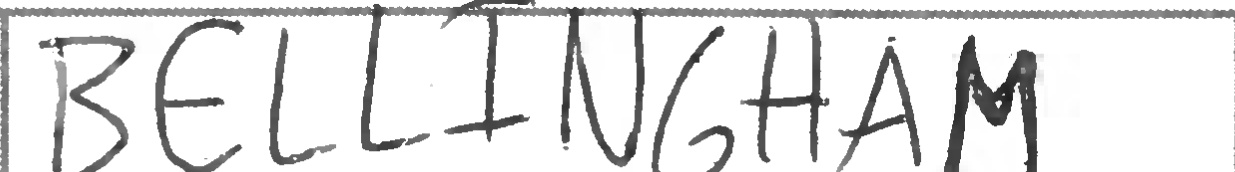

ROI for field 'Date'


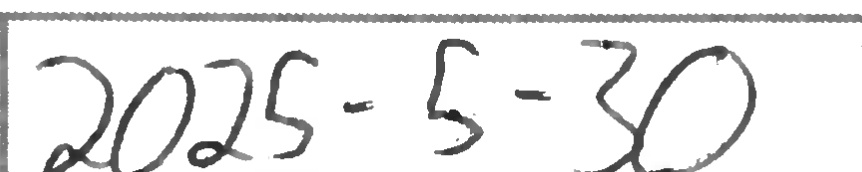

ROI for field 'Investigators1'


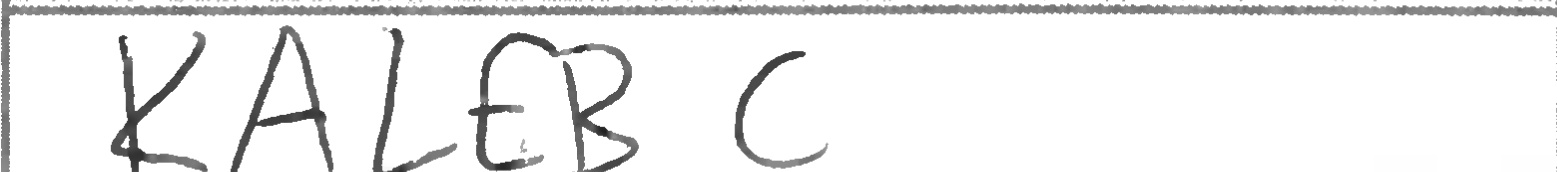

ROI for field 'Investigators2'


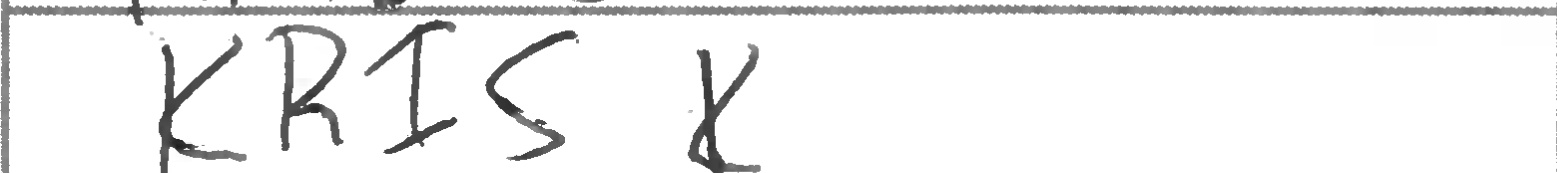

ROI for field 'Investigators3'


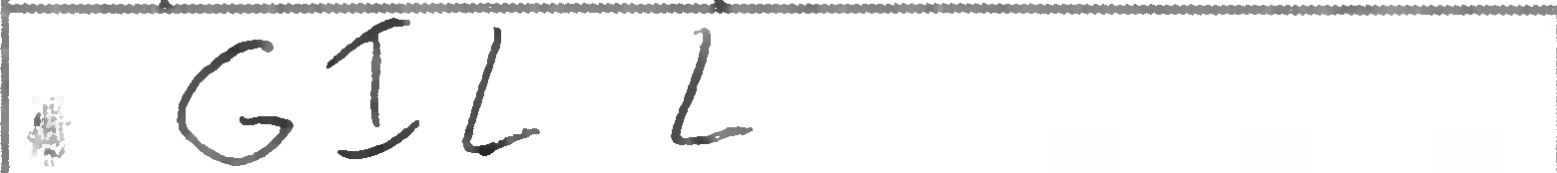

ROI for field 'StartTime1'


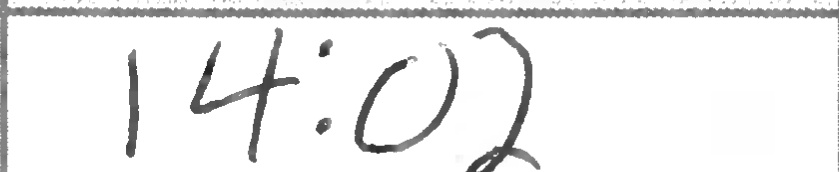

ROI for field 'StartTime2'


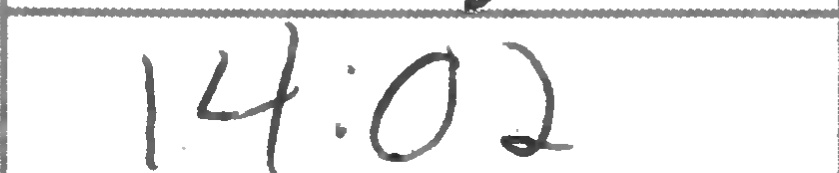

ROI for field 'StartTime3'


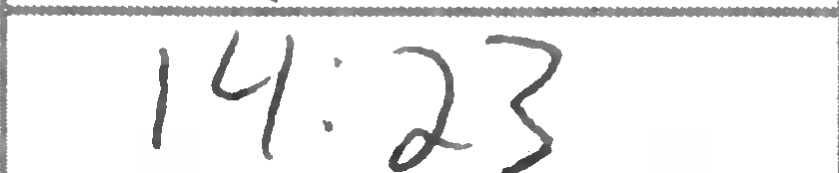

ROI for field 'EndTime1'


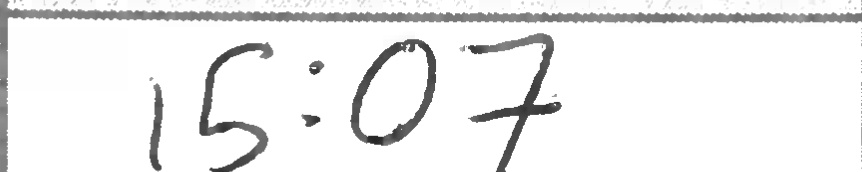

ROI for field 'EndTime2'


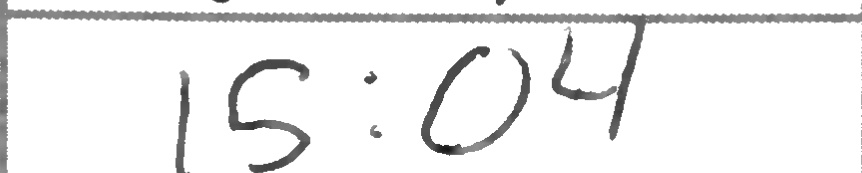

ROI for field 'EndTime3'


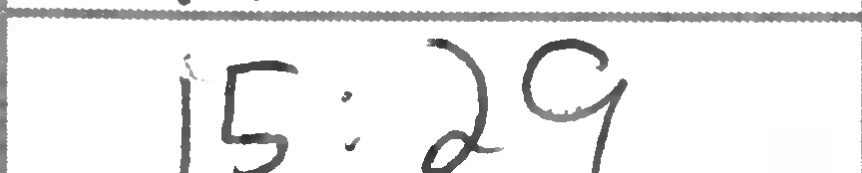

ROI for field 'TideHeight'


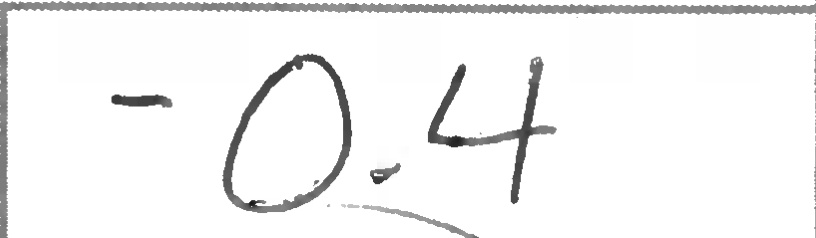

ROI for field 'TideTime'


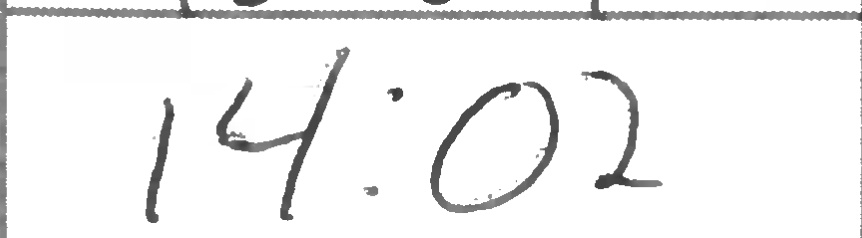

ROI for field 'Rainfall'


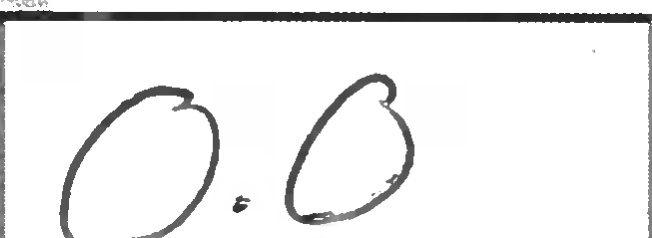

ROI for field 'SiteID1'


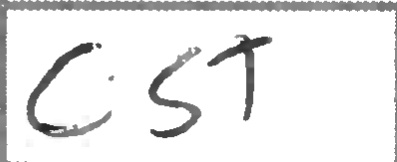

ROI for field 'SiteID2'


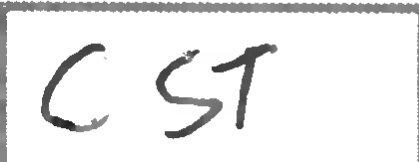

ROI for field 'SiteID3'


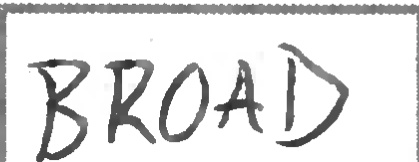

ROI for field 'SiteID4'


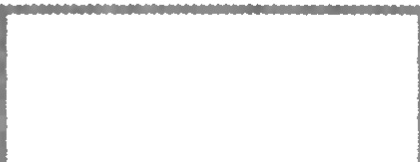

ROI for field 'SiteID5'


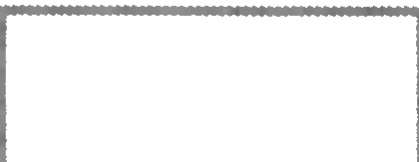

ROI for field 'SiteID6'


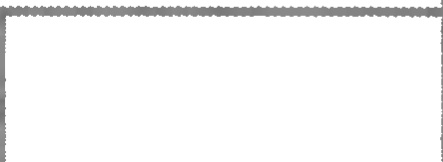

ROI for field 'ArrivalTime1'


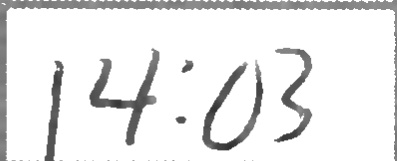

ROI for field 'ArrivalTime2'


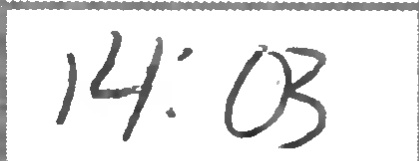

ROI for field 'ArrivalTime3'


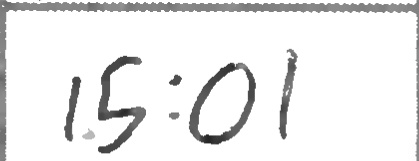

ROI for field 'ArrivalTime4'


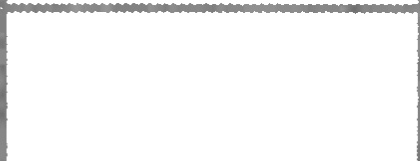

ROI for field 'ArrivalTime5'


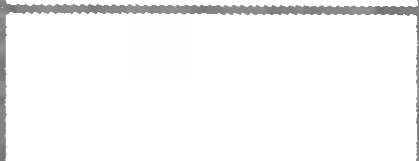

ROI for field 'ArrivalTime6'


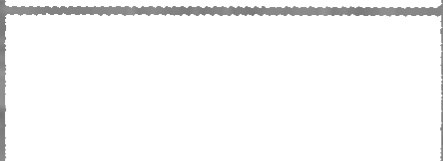

ROI for field 'DryOutfalls1'


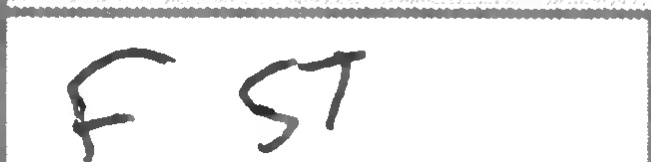

ROI for field 'DryOutfalls2'


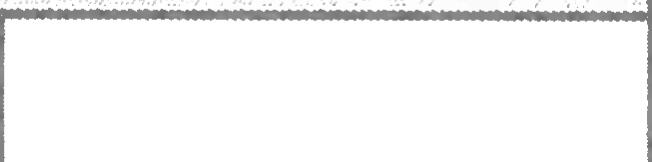

ROI for field 'DryOutfalls3'


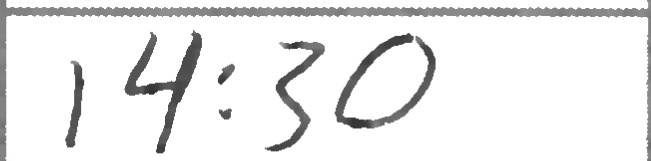

ROI for field 'DryOutfalls4'


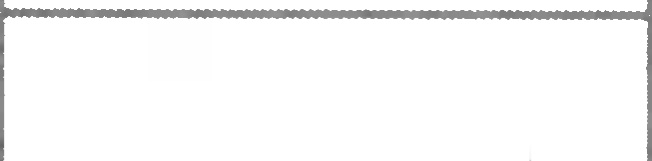

ROI for field 'Flow1'


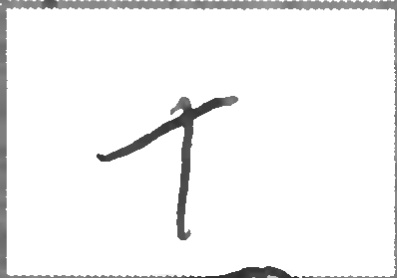

ROI for field 'Flow2'


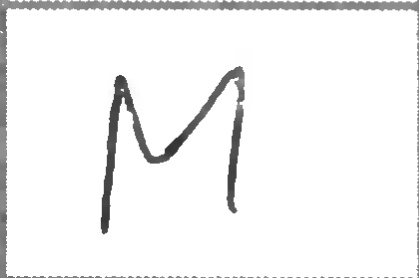

ROI for field 'Flow3'


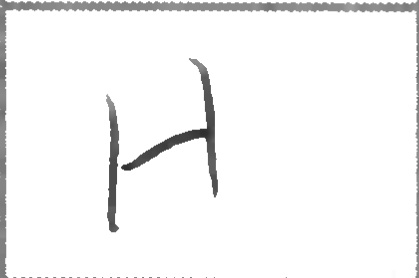

ROI for field 'Flow4'


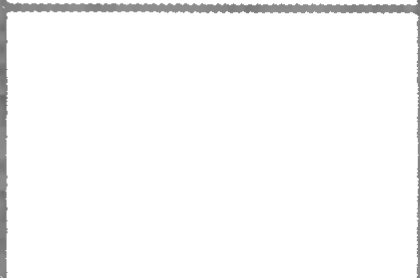

ROI for field 'Flow5'


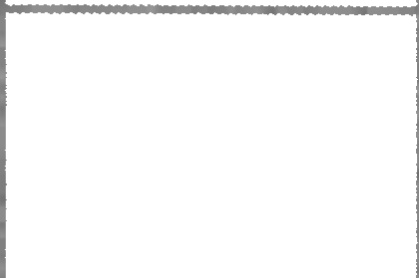

ROI for field 'Flow6'


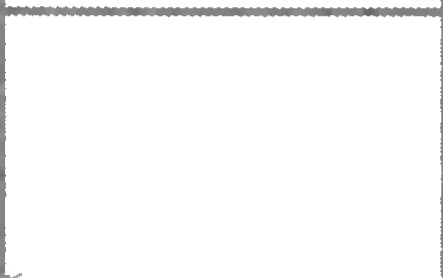

ROI for field 'Notes'


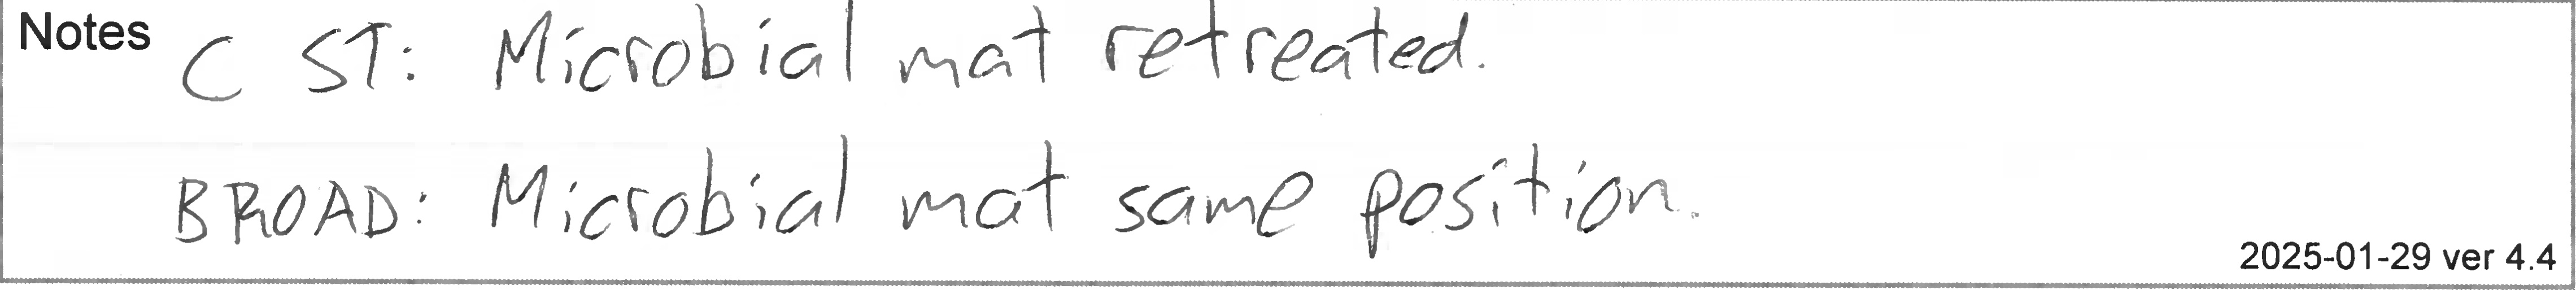

ROI for field 'WaterTemp1'


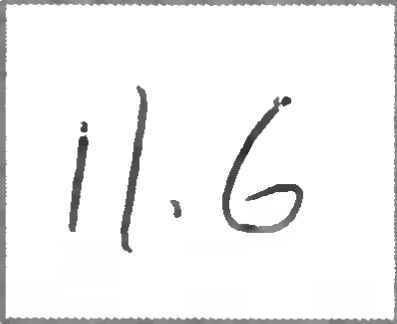

ROI for field 'WaterTemp2'


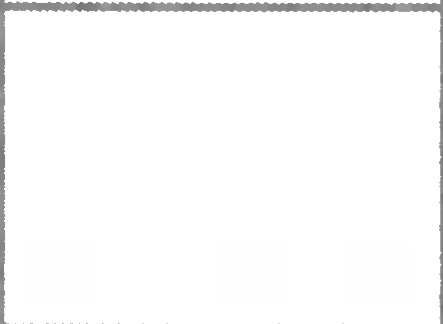

ROI for field 'WaterTemp3'


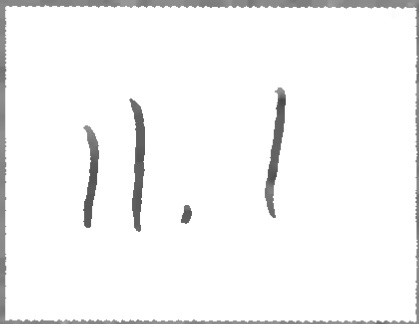

ROI for field 'WaterTemp4'


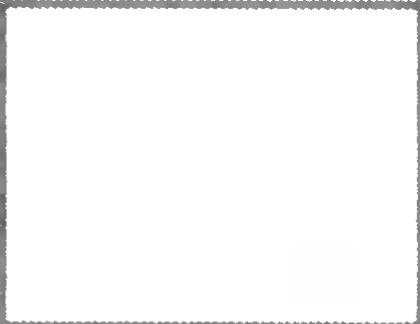

ROI for field 'WaterTemp5'


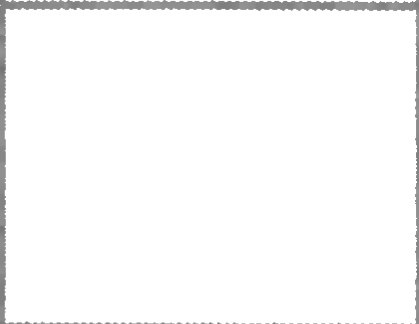

ROI for field 'AirTemp1'


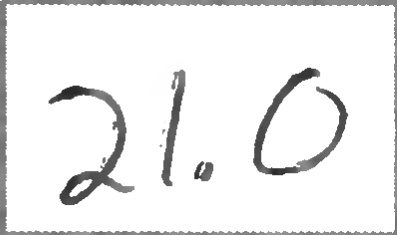

ROI for field 'AirTemp2'


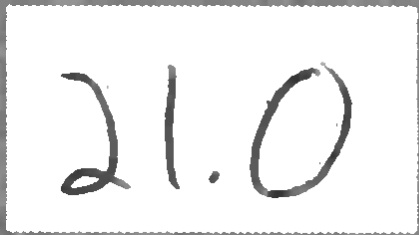

ROI for field 'AirTemp3'


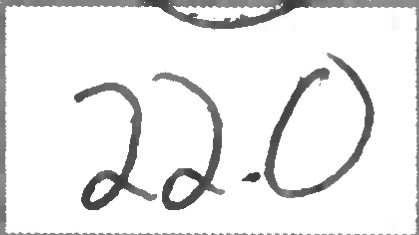

ROI for field 'AirTemp4'


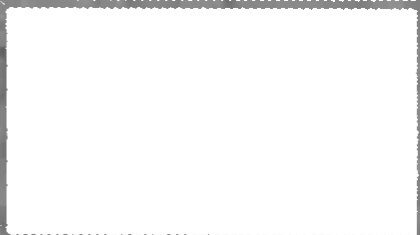

ROI for field 'AirTemp5'


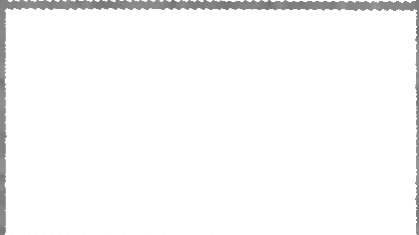

ROI for field 'AirTemp6'


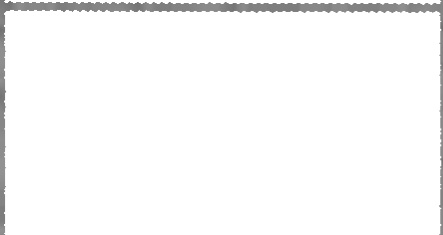

ROI for field 'DO2'


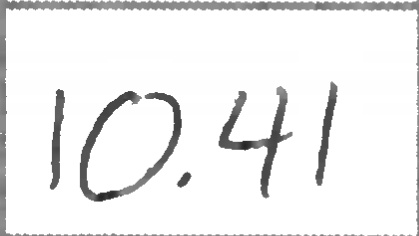

ROI for field 'SPC2'


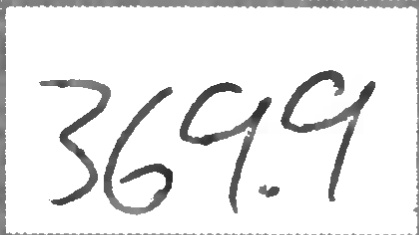

ROI for field 'Salinity2'


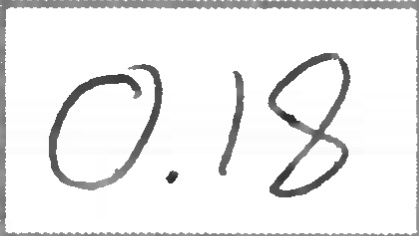

ROI for field 'pH2'


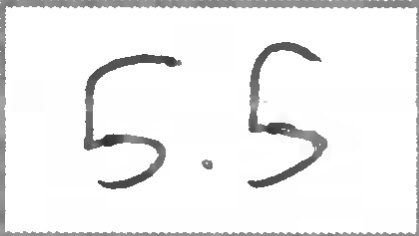

ROI for field 'ColorRank2'


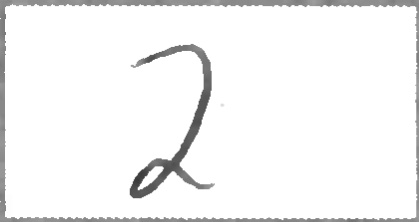

ROI for field 'ColorDesc2'


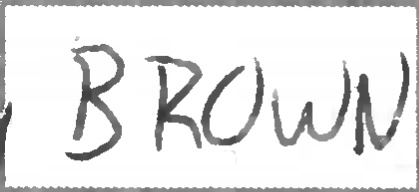

ROI for field 'OdorRank2'


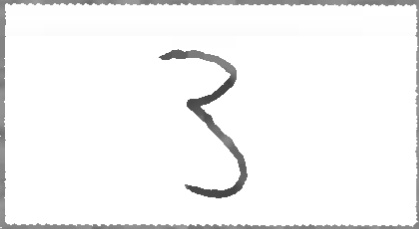

ROI for field 'OdorDesc2'


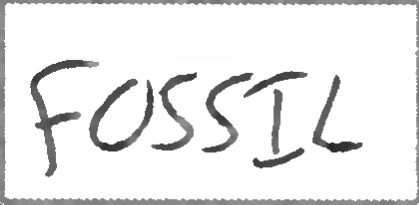

ROI for field 'VisualRank2'


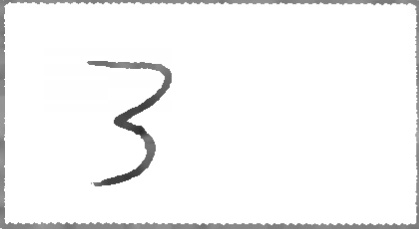

ROI for field 'VisualDesc2'


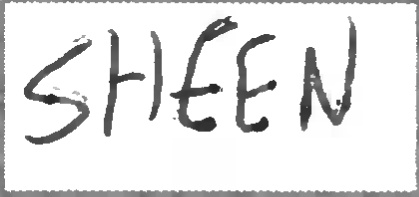

ROI for field 'BottleNum2'


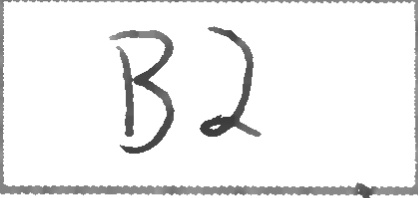

ROI for field 'DO1'


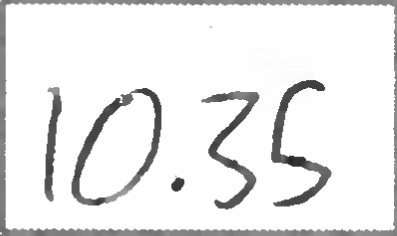

ROI for field 'SPC1'


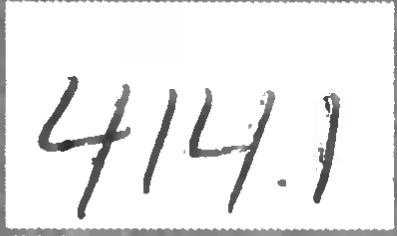

ROI for field 'Salinity1'


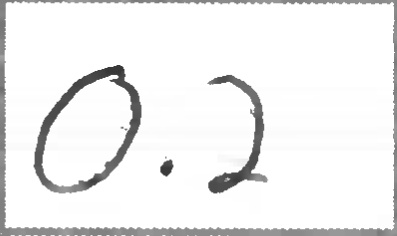

ROI for field 'pH1'


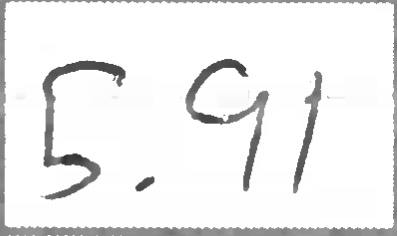

ROI for field 'ColorRank1'


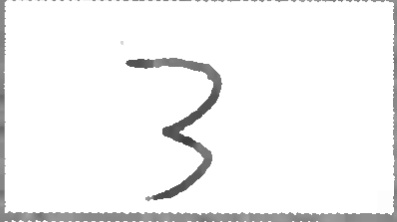

ROI for field 'ColorDesc1'


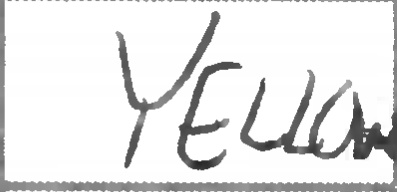

ROI for field 'OdorRank1'


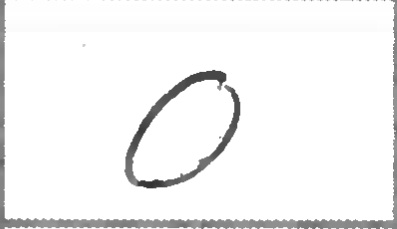

ROI for field 'OdorDesc1'


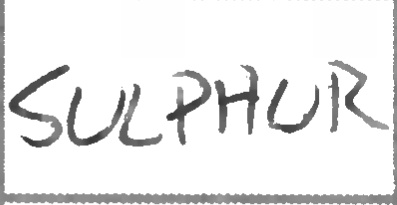

ROI for field 'VisualRank1'


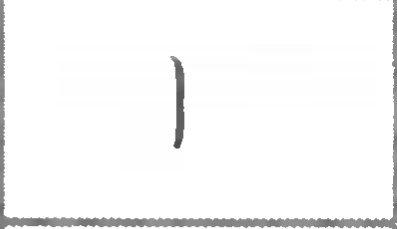

ROI for field 'VisualDesc1'


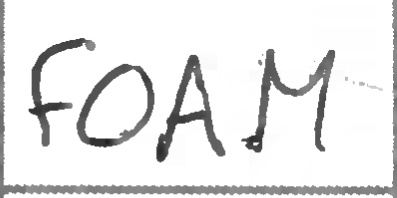

ROI for field 'BottleNum1'


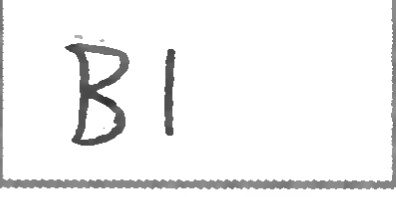

ROI for field 'DO3'


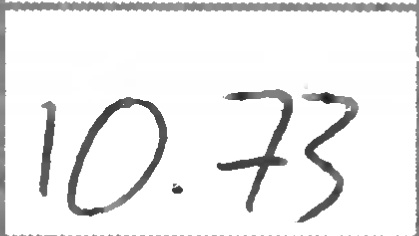

ROI for field 'SPC3'


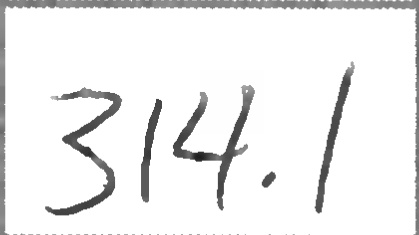

ROI for field 'Salinity3'


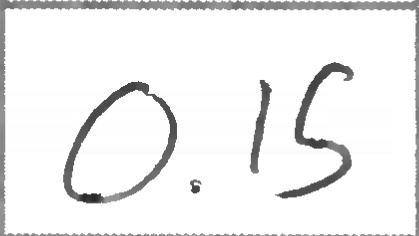

ROI for field 'pH3'


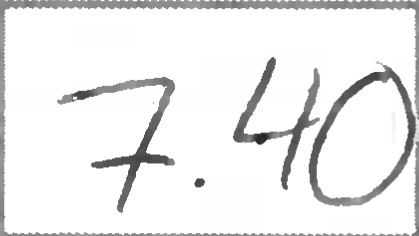

ROI for field 'ColorRank3'


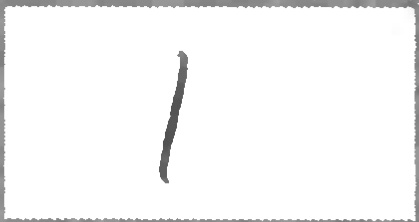

ROI for field 'ColorDesc3'


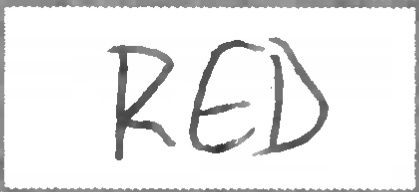

ROI for field 'OdorRank3'


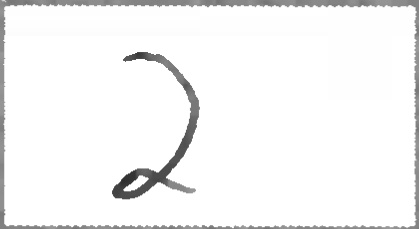

ROI for field 'OdorDesc3'


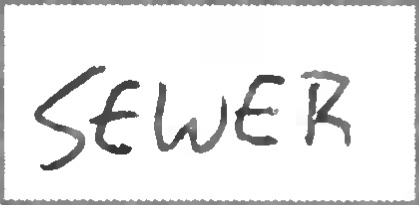

ROI for field 'VisualRank3'


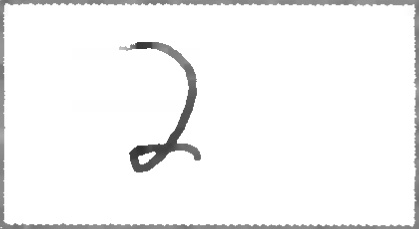

ROI for field 'VisualDesc3'


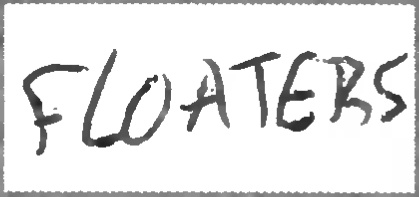

ROI for field 'BottleNum3'


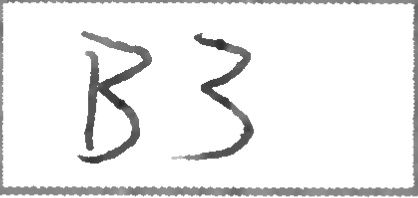

ROI for field 'DO4'


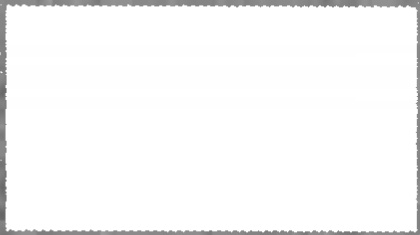

ROI for field 'SPC4'


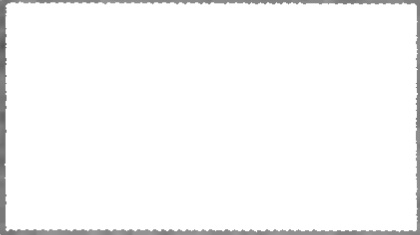

ROI for field 'Salinity4'


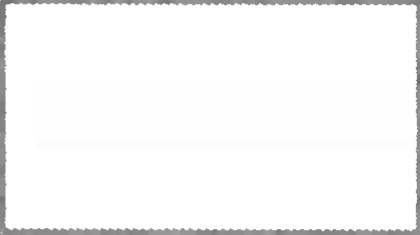

ROI for field 'pH4'


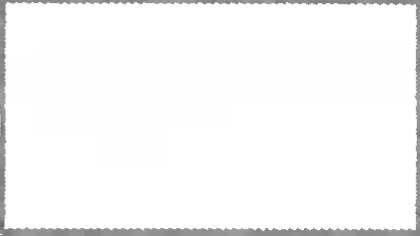

ROI for field 'ColorRank4'


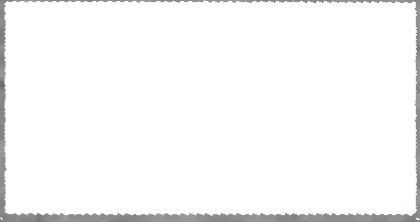

ROI for field 'ColorDesc4'


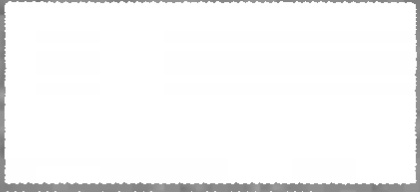

ROI for field 'OdorRank4'


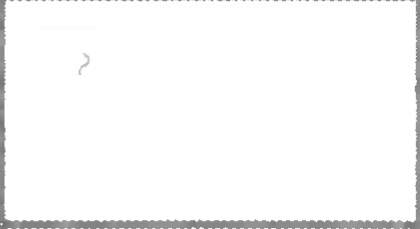

ROI for field 'OdorDesc4'


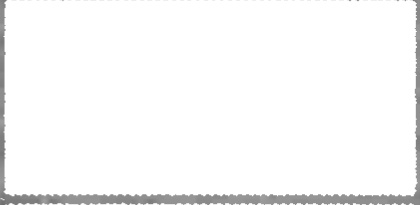

ROI for field 'VisualRank4'


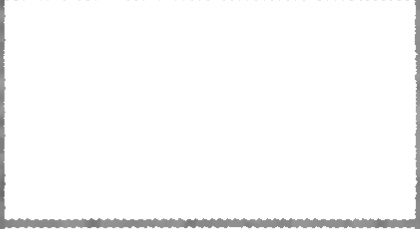

ROI for field 'VisualDesc4'


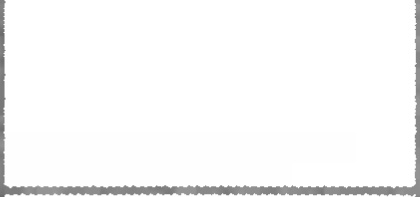

ROI for field 'BottleNum4'


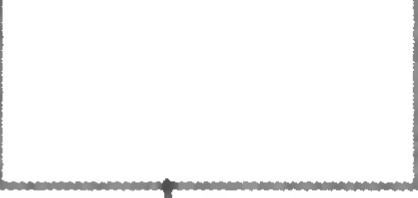

ROI for field 'DO5'


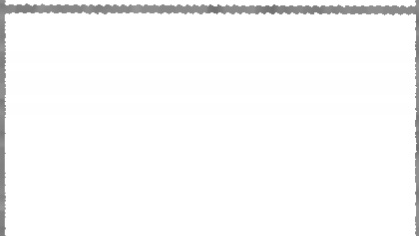

ROI for field 'SPC5'


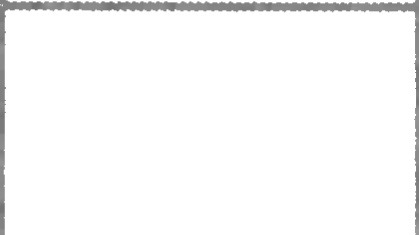

ROI for field 'Salinity5'


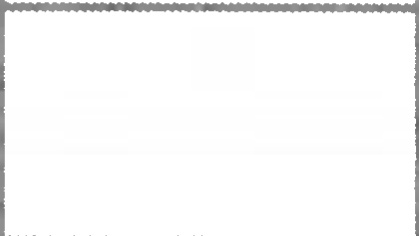

ROI for field 'pH5'


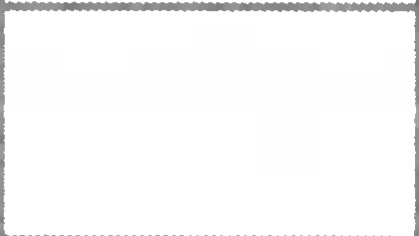

ROI for field 'ColorRank5'


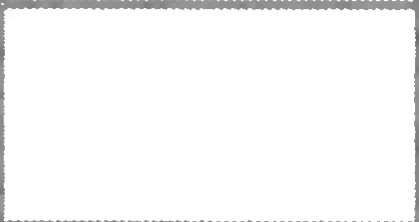

ROI for field 'ColorDesc5'


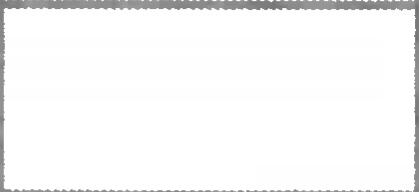

ROI for field 'OdorRank5'


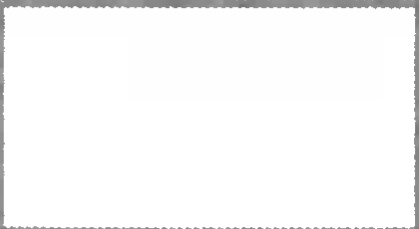

ROI for field 'OdorDesc5'


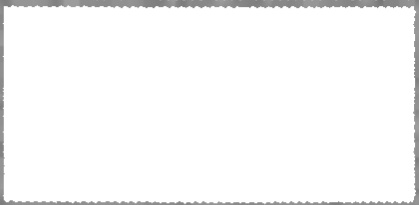

ROI for field 'VisualRank5'


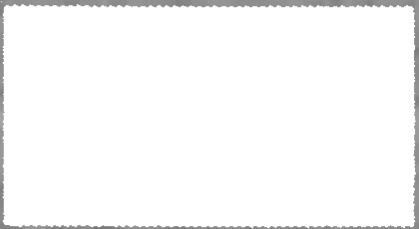

ROI for field 'VisualDesc5'


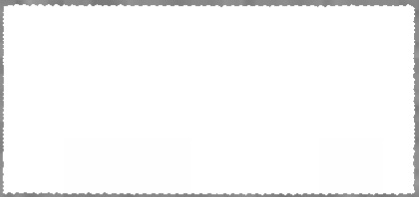

ROI for field 'BottleNum5'


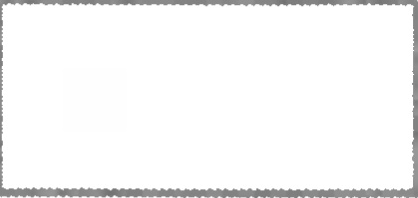

ROI for field 'DO6'


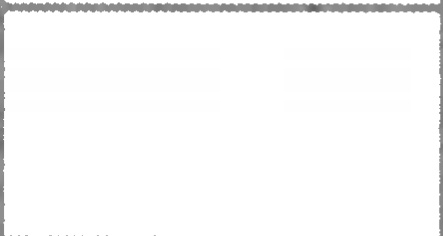

ROI for field 'SPC6'


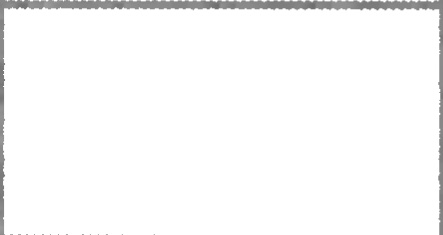

ROI for field 'Salinity6'


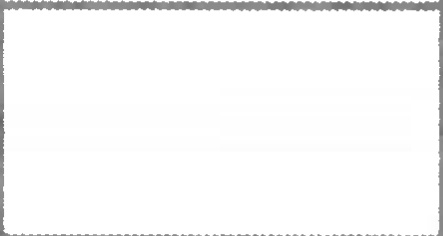

ROI for field 'pH6'


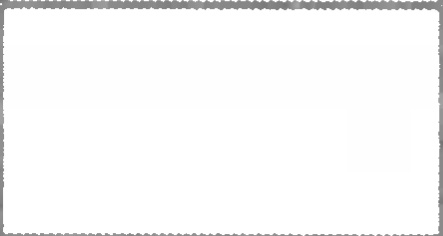

ROI for field 'ColorRank6'


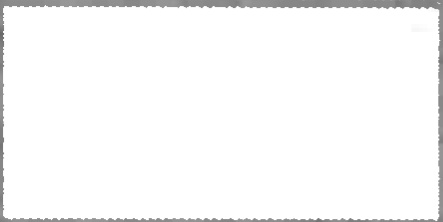

ROI for field 'ColorDesc6'


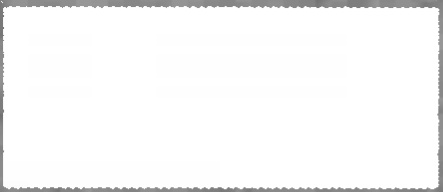

ROI for field 'OdorRank6'


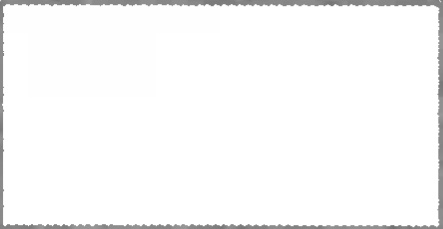

ROI for field 'OdorDesc6'


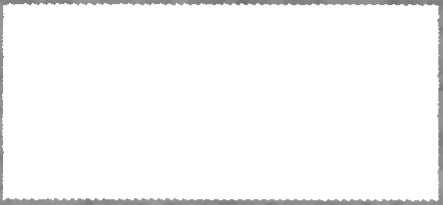

ROI for field 'VisualRank6'


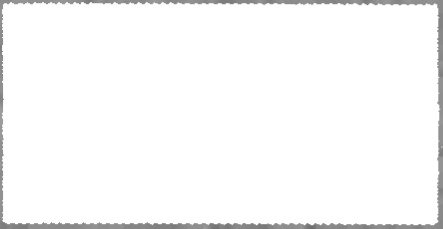

ROI for field 'VisualDesc6'


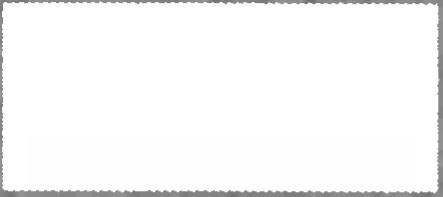

ROI for field 'BottleNum6'


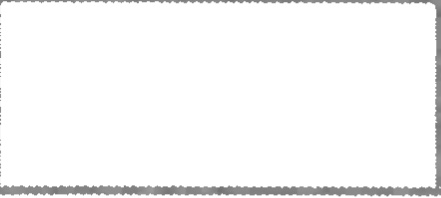

In [13]:
for roi_field_name, roi_data in ROIs.items():
    roi_img_path = Path(f"scratch/roi_{roi_field_name}.jpg")
    print(f"ROI for field '{roi_field_name}'")
    Image(filename=str(roi_img_path), width=200, height=200)


## Apply OCR.

TODO: TBD ... still need to get fiducials in a reliable way that produces accurately bounded ROIs.

In [14]:
# TODO: Use OCR to extract text from the ROIs.